# Importing Dependicies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
import pymysql.cursors
from datetime import datetime

# Importing Data

In [2]:
apld = pd.read_pickle('df_diabetes_s1.pickle')

# Data Filtering

In [3]:
# Paid Claims Only
apld = apld[apld['claim_type'].isin(['pd'])]

In [4]:
# Type 2 Diabetes Only
apld = apld[apld['disease_type'].isin(['t2'])]

In [5]:
# 4 Years of Data
apld['service_date'] = pd.to_datetime(apld['service_date'])

apld = apld[apld['service_date'].between('2019-01-01', '2022-12-31')]

# Exploratory Data Analysis 

### Data Structure

In [6]:
apld['claim_id'].head()

0    517566340
1    387782725
2    999807010
3    999807011
4    999807012
Name: claim_id, dtype: int64

In [7]:
apld['claim_id'].nunique()

152782

In [8]:
apld['claim_id'].count()

152791

In [9]:
len_min = apld['claim_id'].astype(str).str.len().min()
len_max = apld['claim_id'].astype(str).str.len().max()
print(' claim_id length min: '+str(len_min), '\n', 'claim_id length max: '+str(len_max))

 claim_id length min: 9 
 claim_id length max: 10


In [10]:
apld['dup'] = apld.duplicated('claim_id', keep=False)
apld['dup'].value_counts()

False    152773
True         18
Name: dup, dtype: int64

In [11]:
dups = apld[apld['dup'] == 1].sort_values(by=['claim_id'])

In [12]:
len(dups['claim_id'].unique())

9

#### 9 duplicate claim_ids


In [13]:
dups.duplicated(['claim_id', 'patient_id'], keep=False).sum()

0

#### ~ even though we have duplicate claim id's they are not duplicate per patient


In [14]:
trend =  apld.groupby(['service_date']).agg({'service_date': 'count', 'claim_id': 'nunique'}).rename(columns={'service_date': 'count', 'claim_id' : 'nunique'})
trend = trend.resample('M').sum()

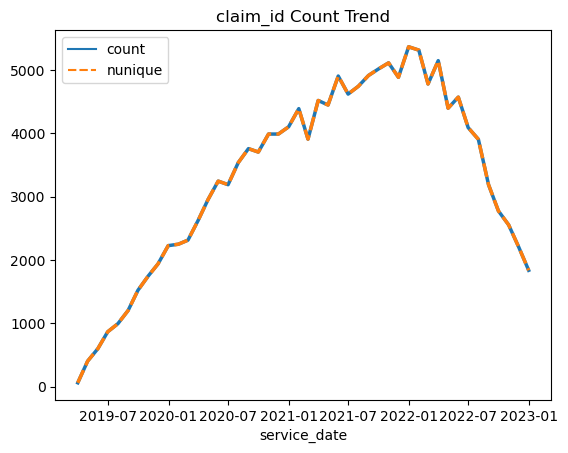

In [15]:
sns.lineplot(data=trend, palette='tab10', linewidth=2.5).set_title('claim_id Count Trend')
plt.show()

#### # ~claim_id count trend: there is an issue in the claim_id count trend, it is downward trending

### Patient ID

In [16]:
apld['patient_id'].head(10)

0    20006
1    20006
2    20006
3    20006
4    20006
5    20006
6    20006
7    20006
8    20006
9    20006
Name: patient_id, dtype: int64

In [17]:
apld['patient_id'].nunique()

9027

#### ~  9,027 unique patients

In [18]:
len_min = apld['patient_id'].astype(str).str.len().min()
len_max = apld['patient_id'].astype(str).str.len().max()
print(' patient_id length min: '+str(len_min), '\n', 'patient_id length max: '+str(len_max))

 patient_id length min: 5 
 patient_id length max: 5


In [19]:
# trend
trend =  apld.groupby(['service_date']).agg({'service_date': 'count', 'patient_id': 'nunique'}).rename(columns={'service_date': 'count', 'patient_id' : 'nunique'})
trend = trend.resample('M').sum()

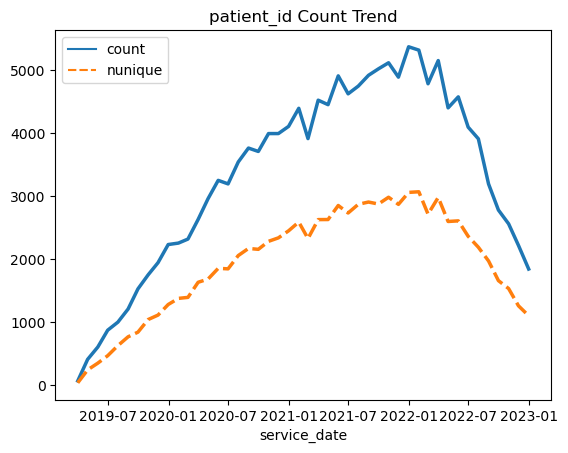

In [20]:
sns.lineplot(data=trend, palette='tab10', linewidth=2.5).set_title('patient_id Count Trend')
plt.show()

### Service Date & Claim Type

In [21]:
apld['claim_type'].unique()

array(['pd'], dtype=object)

In [22]:
apld['claim_type'].nunique()

1

In [23]:
apld['service_date'].min()

Timestamp('2019-03-28 00:00:00')

In [24]:
apld['service_date'].max()

Timestamp('2022-12-31 00:00:00')

### Days Supply

In [25]:
ds_sd, ds_ed = apld['days_supply'].min(), apld['days_supply'].max()
print(ds_sd , ds_ed)

15 90


In [26]:
apld['days_supply'].unique()

array([45, 60, 90, 30, 15, 75])

In [27]:
apld['days_supply'].value_counts(normalize=True).round(2)

45    0.25
30    0.25
60    0.24
90    0.24
15    0.01
75    0.01
Name: days_supply, dtype: float64

### Quantity

In [28]:
q_min = apld['quantity'].min()
q_max = apld['quantity'].max()
print('quantity min: '+str(q_min), '\n', 'quantity max: '+str(q_max))

quantity min: 15 
 quantity max: 90


In [29]:
apld['quantity'].unique()

array([60, 15, 75, 90, 45, 30])

In [30]:
apld['quantity'].value_counts(normalize=True).round(2)

75    0.17
45    0.17
30    0.17
15    0.17
60    0.16
90    0.16
Name: quantity, dtype: float64

### Patient Birth Year

In [31]:
apld_birth = apld[['patient_id', 'patient_birth_year']].drop_duplicates().reset_index(drop=True)
apld_birth['dup_birth'] = apld_birth.duplicated('patient_id', keep=False)

In [32]:
apld_birth['dup_birth'].value_counts()

False    8483
True     1115
Name: dup_birth, dtype: int64

#### Some patients have multiple birth records

In [33]:
dups_birth = apld_birth[apld_birth['dup_birth'] == 1].sort_values(by=['patient_id'])

In [34]:
# Check few patietn records
dups_birth[dups_birth['patient_id'].isin([67773, 94167, 67985])]

,patient_id,patient_birth_year,dup_birth


In [35]:
trend  = apld_birth.groupby(['patient_birth_year']).agg({'patient_id': 'nunique'}).rename(columns={'patient_id' : 'patient_id_count'}).reset_index()

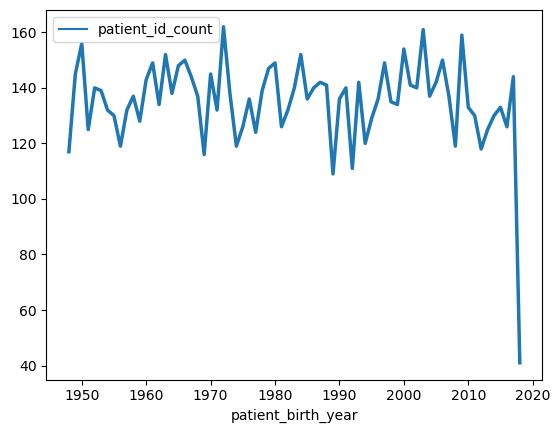

In [36]:
trend['patient_birth_year'] = pd.to_datetime(trend['patient_birth_year'], format='%Y').dt.year
sns.lineplot(data=trend.set_index(['patient_birth_year']), palette='tab10', linewidth=2.5)
plt.show()

### Gender

In [37]:
apld['gender'].value_counts(normalize=True).round(2)*100

m    59.0
f    41.0
Name: gender, dtype: float64

In [38]:
trend = apld.groupby(['service_date', 'gender']).agg({'patient_id': 'nunique'}).reset_index()
trend['service_date'] = pd.to_datetime(trend['service_date'], format='%Y-%m-%d').dt.year

In [39]:
trend = trend.set_index(['service_date'])
trend = trend.reset_index().rename(columns={'patient_id': 'nunique'})

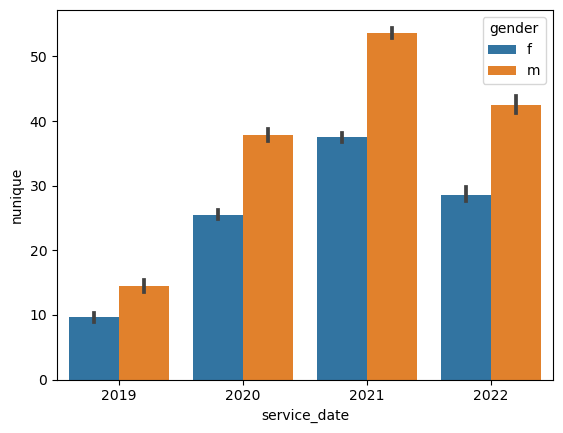

In [40]:
sns.barplot(data =trend, x='service_date', y = 'nunique', hue = 'gender')
plt.show()

### Disease Type

In [41]:
apld['disease_type'].value_counts(normalize=True).round(2)

t2    1.0
Name: disease_type, dtype: float64

In [42]:
trend = apld.groupby(['service_date', 'disease_type']).agg({'patient_id': 'nunique'}).reset_index()
trend['service_date'] = pd.to_datetime(trend['service_date'], format='%Y-%m-%d').dt.year
trend = trend.set_index(['service_date'])
trend = trend.reset_index().rename(columns={'patient_id': 'nunique'})

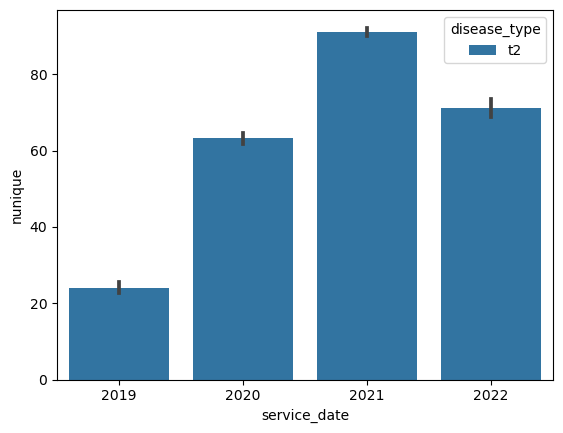

In [43]:
sns.barplot(data =trend, x='service_date', y = 'nunique', hue = 'disease_type')
plt.show()

### NDC, Drug Name

In [44]:
apld['drug_name'].value_counts()

rybelsus        17986
avandia          8868
actos            8859
glucotrol        6019
nesina           5967
januvia          5947
novolin mix      4899
trulicity        4833
diabeta          4749
invokana         4581
humalog          4508
farxiga          4498
jardiance        4497
steglatro        4480
glucophage       4471
metformin        4433
humalog mix      4109
onglyza          3980
glynase          3635
bydureon         3634
amaryl           3603
metformin er     3591
afrezza          3071
adlyxin          2486
victoza          2463
byetta           2436
ozempic          2354
levemir          2265
tresiba          2225
lantus           2204
tradjenta        2016
glumetza         1840
fortamet er      1827
riomet           1821
toujeo           1490
novolog          1426
basaglar          720
Name: drug_name, dtype: int64

In [45]:
apld['drug_name'].value_counts(normalize=True).round(2)

rybelsus        0.12
avandia         0.06
actos           0.06
glucotrol       0.04
nesina          0.04
januvia         0.04
novolin mix     0.03
trulicity       0.03
diabeta         0.03
invokana        0.03
humalog         0.03
farxiga         0.03
jardiance       0.03
steglatro       0.03
glucophage      0.03
metformin       0.03
humalog mix     0.03
onglyza         0.03
glynase         0.02
bydureon        0.02
amaryl          0.02
metformin er    0.02
afrezza         0.02
adlyxin         0.02
victoza         0.02
byetta          0.02
ozempic         0.02
levemir         0.01
tresiba         0.01
lantus          0.01
tradjenta       0.01
glumetza        0.01
fortamet er     0.01
riomet          0.01
toujeo          0.01
novolog         0.01
basaglar        0.00
Name: drug_name, dtype: float64

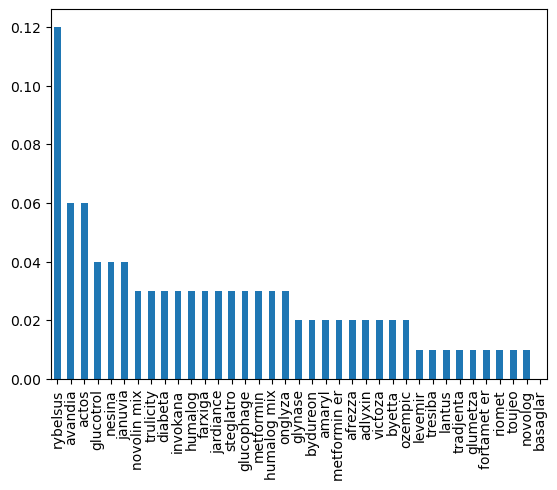

In [46]:
apld['drug_name'].value_counts(normalize=True).round(2).plot(kind='bar'); plt.show()

#### ~ Drug shares doesn't represent real world

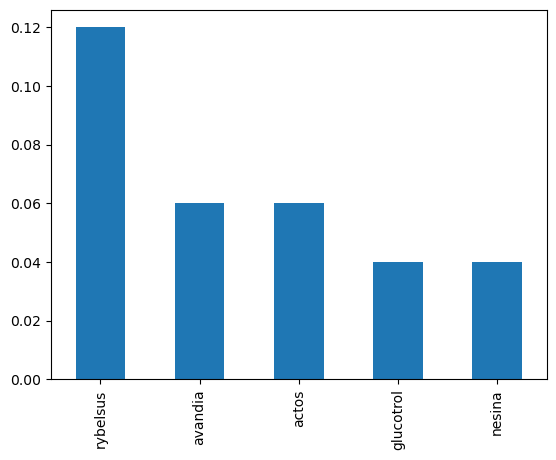

In [47]:
apld['drug_name'].value_counts(normalize=True).round(2).head(5).plot(kind='bar'); plt.show()

### Class and Subclass

In [48]:
apld['class'].value_counts()

incretin    72158
oral        53716
insulin     26917
Name: class, dtype: int64

In [49]:
apld['class'].value_counts(normalize=True).round(2)

incretin    0.47
oral        0.35
insulin     0.18
Name: class, dtype: float64

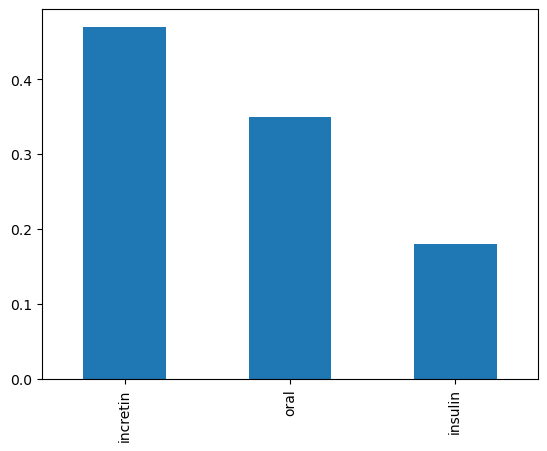

In [50]:
apld['class'].value_counts(normalize=True).round(2).plot(kind='bar'); plt.show()

In [51]:
apld['sub_class'].value_counts(normalize=True).round(2)

glp-1 receptor                 0.24
sglt2 subclass                 0.12
sulfoneureas                   0.12
biguanide                      0.12
dpp-4 subclass                 0.12
thiazolidinediones             0.12
premix insulin                 0.06
rapid acting insulin           0.06
basal (long acting) insulin    0.06
Name: sub_class, dtype: float64

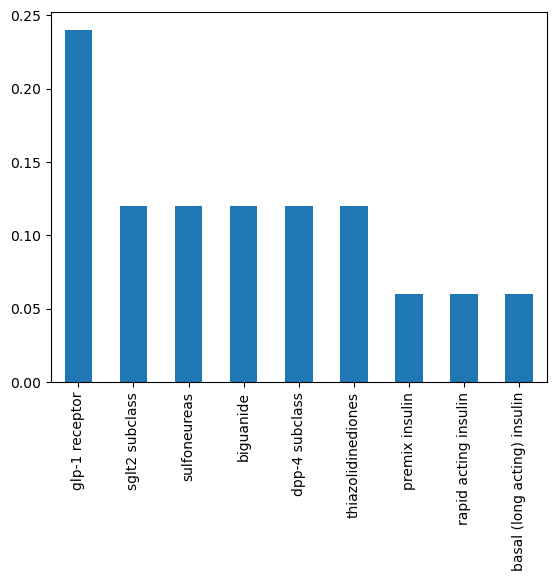

In [52]:
apld['sub_class'].value_counts(normalize=True).round(2).plot(kind= 'bar'); plt.show()

### Mode of Dispensation

In [53]:
apld['mode_of_dispensation'].value_counts(normalize=True).round(2)

oral          0.7
injectable    0.3
Name: mode_of_dispensation, dtype: float64

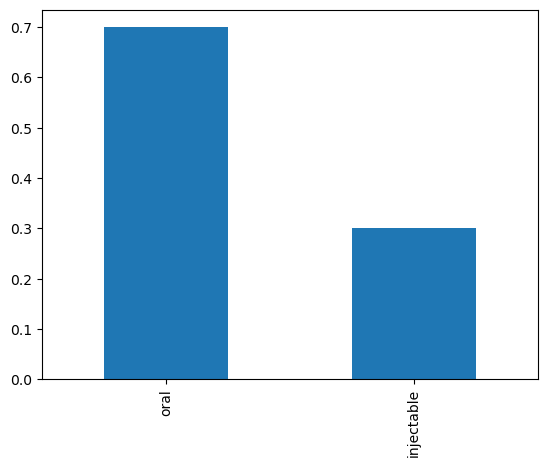

In [54]:
apld['mode_of_dispensation'].value_counts(normalize=True).round(2).plot(kind= 'bar'); plt.show()

### Treatment Hierarchy

In [55]:
apld['treatement_hierarchy'].value_counts(normalize=True).round(2)

8     0.12
6     0.12
2     0.12
7     0.12
1     0.12
5     0.12
3     0.12
9     0.06
10    0.06
11    0.06
Name: treatement_hierarchy, dtype: float64

#### ~ higher % of Claim counts within early stage of treatment

In [56]:
apld['mode_of_dispensation'].value_counts(normalize=True).round(2).reset_index().sort_values(['index'])

,index,mode_of_dispensation
1,injectable,0.3
0,oral,0.7


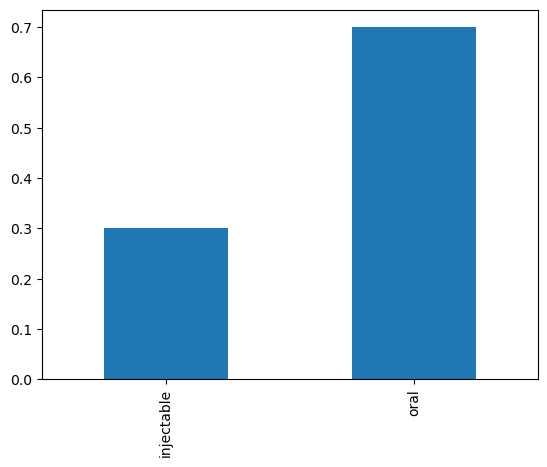

In [57]:
apld['mode_of_dispensation'].value_counts(normalize=True).round(2).sort_index().plot(kind= 'bar'); plt.show()

### Past Medical History

In [58]:
apld['past_medical_history'].value_counts(normalize=True).round(2)

n    0.72
y    0.28
Name: past_medical_history, dtype: float64

#### ~ 28% of patients have past medical history

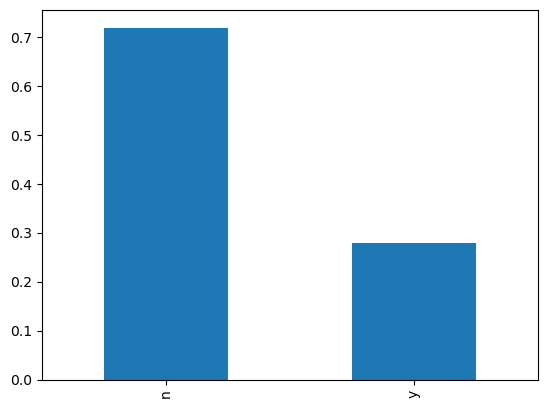

In [59]:
apld['past_medical_history'].value_counts(normalize=True).round(2).plot(kind= 'bar'); plt.show()

### Family History

In [60]:
apld['family_history'].value_counts(normalize=True).round(2)

n    0.81
y    0.19
Name: family_history, dtype: float64

#### ~ 19% of patients have family history

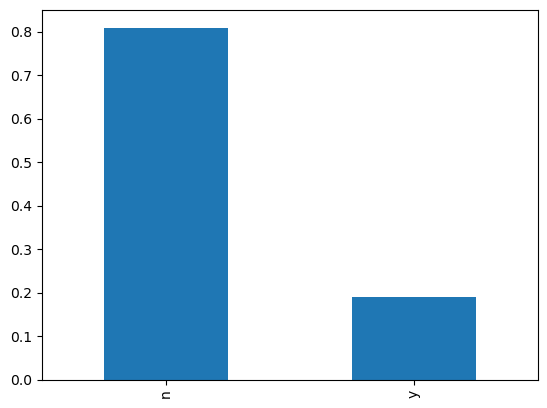

In [61]:
apld['family_history'].value_counts(normalize=True).round(2).plot(kind= 'bar'); plt.show()

### Is there Complication?

In [62]:
apld['is_there_complication'].value_counts(normalize=True).round(2)

y    0.67
n    0.33
Name: is_there_complication, dtype: float64

#### ~ 67% of patients have previous complication

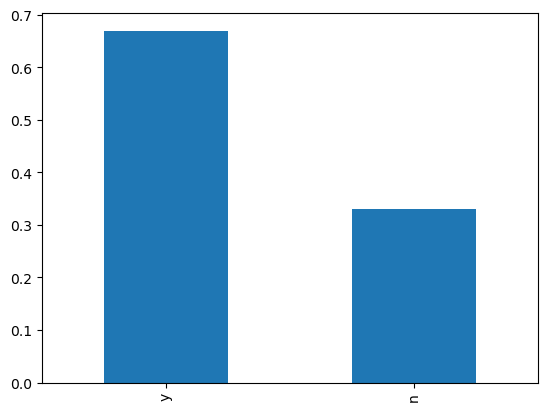

In [63]:
apld['is_there_complication'].value_counts(normalize=True).round(2).plot(kind= 'bar'); plt.show()

### Marital Status

In [64]:
apld['marital_status'].value_counts(normalize=True).round(2)

married    0.62
single     0.38
Name: marital_status, dtype: float64

#### ~38% of patients are single and 62% are married

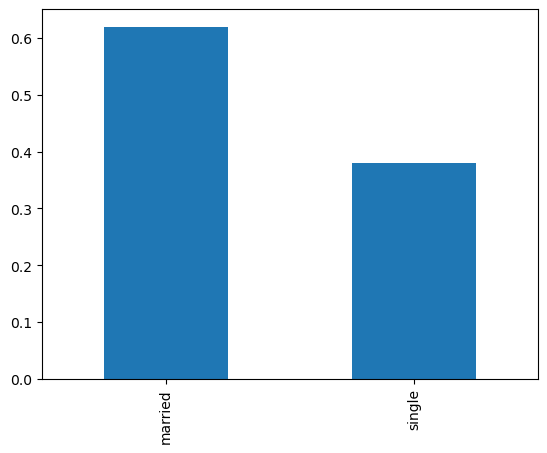

In [65]:
apld['marital_status'].value_counts(normalize=True).round(2).plot(kind= 'bar'); plt.show()

### Educational Status

In [66]:
apld['educational_status'].value_counts(normalize=True).round(2)

educated      0.77
uneducated    0.23
Name: educational_status, dtype: float64

#### ~ 23% patients are uneducated

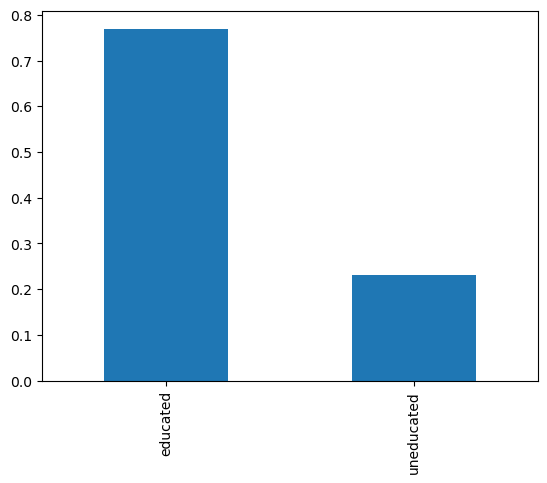

In [67]:
apld['educational_status'].value_counts(normalize=True).round(2).plot(kind= 'bar'); plt.show()

## Feature Creation

In [68]:
# take max birth date for each patient
_age = apld.groupby('patient_id').agg({'patient_birth_year': 'max'}).reset_index()
now = datetime.now()

In [69]:
_age['age'] = now.year - _age['patient_birth_year']

#### Derive Time on Therapy (tot)

In [70]:
apld['drug_supply_next_dt'] = apld['service_date'] + pd.to_timedelta(apld['days_supply'], unit='d')

In [71]:
# Patient's prospective first and last date on therapy
_tot = apld.groupby('patient_id').agg({'service_date': 'min', 'drug_supply_next_dt': 'max'}).reset_index().rename(columns={'service_date': 'drug_supply_first_dt', 'drug_supply_next_dt': 'drug_supply_last_dt'})

In [72]:
_tot['dup'] = _tot.duplicated('patient_id', keep=False)
_tot['dup'].value_counts()

False    9027
Name: dup, dtype: int64

In [73]:
del _tot['dup']
#dups = _tot[_tot['dup'] == 1].sort_values(by=['patient_id'])

In [74]:
# derive tot
_tot['tot'] = (_tot['drug_supply_last_dt'] - _tot['drug_supply_first_dt']).dt.days
_tot['total_time'] = (pd.Timestamp('2022-12-31') - pd.Timestamp('2019-01-01')).days

In [75]:
# derive survived flag
_tot['survived'] = np.where(_tot['drug_supply_last_dt'] >= pd.Timestamp('2022-12-31'), 1, 0)

In [76]:
# survival summary
_tot['survived'].value_counts(normalize=True)

0    0.762269
1    0.237731
Name: survived, dtype: float64

#### ~Overall 70% of patients survived

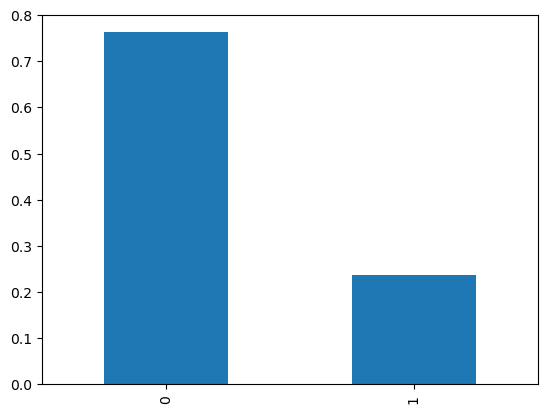

In [77]:
_tot['survived'].value_counts(normalize=True).plot(kind='bar'); plt.show()

### Derive Days Covered

In [78]:
_dc = apld.groupby('patient_id').agg({'days_supply': 'sum'}).reset_index().rename(columns={'days_supply': 'pdc'})

In [79]:
apld.head(2)

,claim_id,patient_id,service_date,claim_type,days_supply,quantity,patient_birth_year,gender,disease_type,ndc,...,mode_of_dispensation,treatement_hierarchy,past_medical_history,family_history,is_there_complication,marital_status,educational_status,employee_status,dup,drug_supply_next_dt
0,517566340,20006,2021-10-30,pd,45,60,1963,m,t2,47152818127,...,oral,7,y,n,y,married,educated,unemployed,False,2021-12-14
1,387782725,20006,2021-12-14,pd,60,15,1963,m,t2,83161652750,...,oral,7,y,n,y,married,educated,unemployed,False,2022-02-12


In [80]:
# Combine
apld = pd.merge(apld, _tot[['patient_id', 'drug_supply_first_dt', 'drug_supply_last_dt', 'tot', 'total_time', 'survived']], on=['patient_id'], how='left')

In [81]:
apld = pd.merge(apld, _dc, on = ['patient_id'], how = 'left')

In [82]:
apld = pd.merge(apld, _age[['patient_id', 'age']], on=['patient_id'], how='left')

## Decide on Cohort

In [83]:
input = ['patient_id', 'drug_supply_first_dt','gender', 'age', 'past_medical_history', 'family_history', 'is_there_complication', 'marital_status', 'educational_status', 'employee_status', 'tot', 'survived', 'total_time', 'pdc']

In [84]:
# filters : claim_types = 'pd
df_apld = apld[input].drop_duplicates()

In [96]:
df_apld.head(5).T

,0,20,23,54,71
patient_id,20006,20021,20023,20038,20044
drug_supply_first_dt,2021-10-30 00:00:00,2022-03-18 00:00:00,2019-10-13 00:00:00,2019-08-18 00:00:00,2019-06-03 00:00:00
gender,m,f,f,m,m
age,60,62,43,43,52
past_medical_history,y,n,y,n,n
family_history,n,y,n,n,n
is_there_complication,y,y,y,n,y
marital_status,married,single,married,married,married
educational_status,educated,educated,educated,uneducated,educated
employee_status,unemployed,unemployed,unemployed,unemployed,unemployed


### Duplicates

In [86]:
df_apld['dup'] = df_apld.duplicated('patient_id', keep=False)
df_apld['dup'].value_counts()

False    8761
True      532
Name: dup, dtype: int64

#### ~532 duplicate entries

In [87]:
dups = df_apld[df_apld['dup'] == 1].sort_values(by=['patient_id'])
dups

,patient_id,drug_supply_first_dt,gender,age,past_medical_history,family_history,is_there_complication,marital_status,educational_status,employee_status,tot,survived,total_time,pdc,dup
366,20227,2019-04-25,f,22,n,n,n,married,educated,employee,1318,0,1460,2880,True
384,20227,2019-04-25,m,22,y,n,y,single,uneducated,unemployed,1318,0,1460,2880,True
1213,20646,2020-03-14,f,51,n,n,n,married,uneducated,employee,1037,1,1460,2700,True
1236,20646,2020-03-14,m,51,n,n,y,married,educated,unemployed,1037,1,1460,2700,True
2529,21218,2020-05-12,f,9,y,n,y,single,uneducated,employee,1012,1,1460,1290,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151995,99458,2019-10-05,m,26,n,n,y,married,educated,unemployed,1016,0,1460,1875,True
152153,99549,2021-07-07,m,29,n,n,n,married,educated,unemployed,505,0,1460,1710,True
152156,99549,2021-07-07,f,29,y,y,y,single,educated,unemployed,505,0,1460,1710,True
152581,99793,2020-11-30,m,35,n,n,y,married,educated,employee,668,0,1460,1575,True


In [88]:
# sample
dups[dups['patient_id'].isin([20227])].T

,366,384
patient_id,20227,20227
drug_supply_first_dt,2019-04-25 00:00:00,2019-04-25 00:00:00
gender,f,m
age,22,22
past_medical_history,n,y
family_history,n,n
is_there_complication,n,y
marital_status,married,single
educational_status,educated,uneducated
employee_status,employee,unemployed


In [89]:
# Drop duplicates
df_apld = df_apld[df_apld['dup'] == 0]
del df_apld['dup']

In [90]:
# Trend
trend  = df_apld.groupby(['drug_supply_first_dt']).agg({'drug_supply_first_dt': 'count', 'patient_id': 'nunique'}).rename(columns={'drug_supply_first_dt': 'count', 'patient_id': 'nunique'})

In [91]:
trend = trend.resample('M').sum()

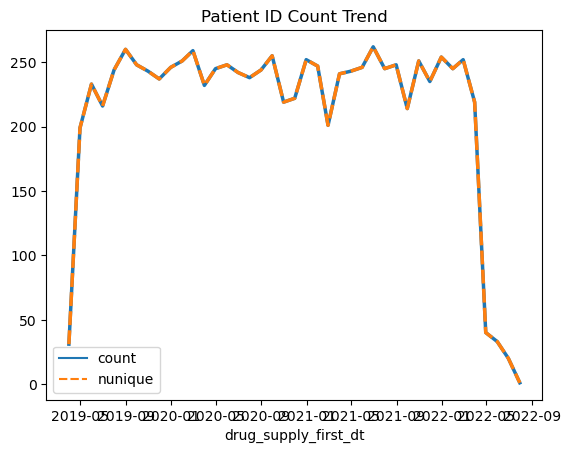

In [92]:
sns.lineplot(data=trend, palette="tab10", linewidth=2.5).set_title('Patient ID Count Trend'); plt.show()

In [101]:
# Take cohort of patients who started therapy between Jan 2019 and June 2019
df_cohort = df_apld[df_apld['drug_supply_first_dt'].between('2019-01-01', '2019-06-30')].reset_index(drop=True)

In [100]:
df_cohort.nunique()

patient_id               679
drug_supply_first_dt      94
gender                     2
age                       71
past_medical_history       2
family_history             2
is_there_complication      2
marital_status             2
educational_status         2
employee_status            2
tot                      505
survived                   2
total_time                 1
pdc                      197
dtype: int64

In [102]:
df_cohort.age.min() , df_cohort.age.max()

(5, 75)